I think this project deserves a Complete. Rather than just using the viola jones model that was introduced earlier in class, I decided to investigate other models that are able to complete the same job. I wanted to see what the different processing times are for each model. I had the most fun playing around with the MTCNN model.

I wish I had more time to figure out how to implament these models into a live video. With that being said, my program works on images with more than 4 faces in it which I am very proud of.

In [ ]:
pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 27.6 MB/s eta 0:00:00


In [ ]:
! pip install --upgrade --quiet ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.9/756.9 kB 8.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from mtcnn import MTCNN
import dlib

from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
import io
import html
import time
from base64 import b64decode, b64encode
from PIL import Image
from ultralytics import YOLO
from ultralytics.engine.results import Results
import os

# Download the Haar Cascade face detection model
url = 'https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml'
!curl -o haarcascade_frontalface_default.xml {url}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  908k  100  908k    0     0  1824k      0 --:--:-- --:--:-- --:--:-- 1827k


In [ ]:
# Adapted from: https://colab.research.google.com/drive/1QnC7lV7oVFk5OZCm75fqbLAfD9qBy9bw?usp=sharing#scrollTo=09b_0FAnUa9y
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))

  # get OpenCV format image
  img = js_to_image(data)
  return img

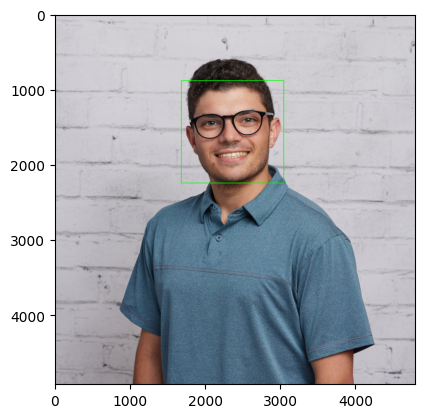

In [ ]:
# Make a copy of the image to draw on
image_path = '/content/image.jpeg'
img = cv2.imread(image_path)
disp = img.copy()


# Make a grayscale version for detection (the model was trained on gray images)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Run detection
# bounding_boxes is a list of 4-element tuples, e.g., [(x, y, w, h)]
bounding_boxes = face_cascade.detectMultiScale(gray,scaleFactor=1.4, minNeighbors=9, minSize=(35, 35))

# loop over each detection (bounding box)
for (x, y, w, h) in bounding_boxes:
    # draw the bounding box on the display image
    disp = cv2.rectangle(disp, (x, y), (x+w, y+h), (0, 255, 0), 8)

disp = cv2.cvtColor(disp, cv2.COLOR_BGR2RGB)
plt.imshow(disp)
plt.show()


This was my first seciton of trial and error. I had to be patient wiht myself inorder to find the correct hyper parameters for the Haar Cascade model. When I intially tried this model on different images, it thought that my shin.foot was a face. I found that increasing the number of neighbors helped solve that issue.

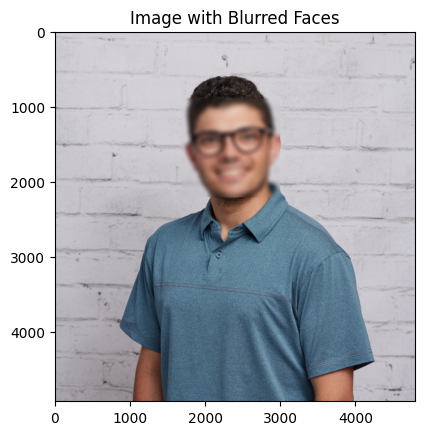

In [ ]:
def blur_faces(image_path):
    # Load the image
    img = cv2.imread(image_path)

    # Load the pre-trained face detection model provided by OpenCV
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Convert the image to grayscale (required for face detection)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray,scaleFactor=1.2, minNeighbors=9, minSize=(30, 30))

    # Blur each face found
    for (x, y, w, h) in faces:
        face_roi = img[y:y+h, x:x+w]
        blurred_face = cv2.GaussianBlur(face_roi, (99, 99), 30)  # Adjust the parameters to change blurring
        img[y:y+h, x:x+w] = blurred_face

 # Convert the image to RGB before displaying
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Save or display the modified image
    cv2.imwrite('blurred_faces_output.jpg', img)  # Save the image

    # Display the image
    plt.imshow(img_rgb)
    plt.title('Image with Blurred Faces')
    plt.show()

# Usage
blur_faces('/content/image.jpeg')

My goal was to blur the image just enough so that the compositon is not ruined. If you have never met me before you probably would not be able to figure out that I am the person in that image. Keep in mind that the majority of the images I used to test are on the large side.

### Multiple faces

6/6 [==============================] - 0s 32ms/step


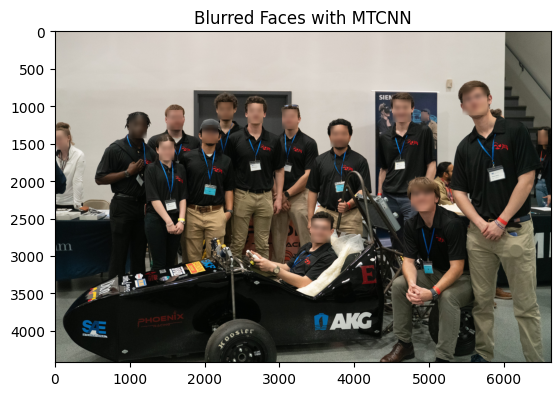

In [ ]:
def detect_faces_mtcnn(image_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    detector = MTCNN()

    faces = detector.detect_faces(img_rgb)
    for face in faces:
        (x, y, w, h) = face['box']
        face_region = img[y:y+h, x:x+w]
        blurred_face = cv2.GaussianBlur(face_region, (99, 99), 30)
        img[y:y+h, x:x+w] = blurred_face

     # Convert the image to RGB before displaying
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Save or display the modified image
    cv2.imwrite('blurred_faces_output_mtcnn.jpg', img)  # Save the image

    # Display the image
    plt.imshow(img_rgb)
    plt.title('Blurred Faces with MTCNN')
    plt.show()


detect_faces_mtcnn('/content/image3.jpeg')

I was super impressed with how this model turned out. It was able to detect every face in the image, forground, midground, and background.

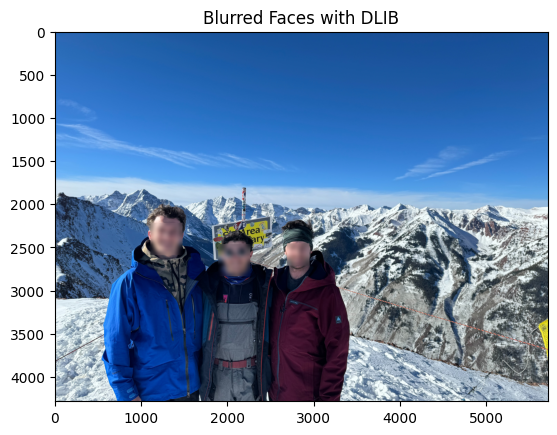

In [ ]:
def detect_faces_dlib(image_path):
    img = cv2.imread(image_path)
    detector = dlib.get_frontal_face_detector()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)

    for face in faces:
        x, y, w, h = face.left(), face.top(), face.width(), face.height()
        face_region = img[y:y+h, x:x+w]
        blurred_face = cv2.GaussianBlur(face_region, (99, 99), 30)
        img[y:y+h, x:x+w] = blurred_face

    # Convert the image to RGB before displaying
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Save or display the modified image
    cv2.imwrite('blurred_faces_output_DLIB.jpg', img)  # Save the image

    # Display the image
    plt.imshow(img_rgb)
    plt.title('Blurred Faces with DLIB')
    plt.show()
# Usage
detect_faces_dlib('/content/image2.jpeg')

In this example I wanted to see if a complex background would hinder this models performance in any way. This image has a lof of light reflecting on many mountians creating intracite angles. I though that the model would miss a face or plur out an extra section but it did not.

In [ ]:
PRE_TRAINED_MODEL = YOLO('yolov8n.pt')
IMG_SHAPE = [640, 480]
IMG_QUALITY = 0.8

In [ ]:
def start_stream():
    js = Javascript(f'''
    const IMG_SHAPE = {IMG_SHAPE};
    const IMG_QUALITY = {IMG_QUALITY};
    ''' + '''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
        stream.getVideoTracks()[0].stop();
        video.remove();
        div.remove();
        video = null;
        div = null;
        stream = null;
        imgElement = null;
        captureCanvas = null;
        labelElement = null;
    }

    function onAnimationFrame() {
        if (!shutdown) {
            window.requestAnimationFrame(onAnimationFrame);
        }
        if (pendingResolve) {
            var result = "";
            if (!shutdown) {
                captureCanvas.getContext('2d').drawImage(video, 0, 0, IMG_SHAPE[0], IMG_SHAPE[1]);
                result = captureCanvas.toDataURL('image/jpeg', IMG_QUALITY)
            }
            var lp = pendingResolve;
            pendingResolve = null;
            lp(result);
        }
    }

    async function createDom() {
        if (div !== null) {
            return stream;
        }

        div = document.createElement('div');
        div.style.border = '2px solid black';
        div.style.padding = '3px';
        div.style.width = '100%';
        div.style.maxWidth = '600px';
        document.body.appendChild(div);

        const modelOut = document.createElement('div');
        modelOut.innerHTML = "<span>Status: </span>";
        labelElement = document.createElement('span');
        labelElement.innerText = 'No data';
        labelElement.style.fontWeight = 'bold';
        modelOut.appendChild(labelElement);
        div.appendChild(modelOut);

        video = document.createElement('video');
        video.style.display = 'block';
        video.width = div.clientWidth - 6;
        video.setAttribute('playsinline', '');
        video.onclick = () => { shutdown = true; };
        stream = await navigator.mediaDevices.getUserMedia(
            {video: { facingMode: "environment"}});
        div.appendChild(video);

        imgElement = document.createElement('img');
        imgElement.style.position = 'absolute';
        imgElement.style.zIndex = 1;
        imgElement.onclick = () => { shutdown = true; };
        div.appendChild(imgElement);

        const instruction = document.createElement('div');
        instruction.innerHTML =
            '<span style="color: red; font-weight: bold;">' +
            'When finished, click here or on the video to stop this demo</span>';
        div.appendChild(instruction);
        instruction.onclick = () => { shutdown = true; };

        video.srcObject = stream;
        await video.play();

        captureCanvas = document.createElement('canvas');
        captureCanvas.width = IMG_SHAPE[0]; //video.videoWidth;
        captureCanvas.height = IMG_SHAPE[1]; //video.videoHeight;
        window.requestAnimationFrame(onAnimationFrame);

        return stream;
    }
    async function takePhoto(label, imgData) {
        if (shutdown) {
            removeDom();
            shutdown = false;
            return '';
        }

        var preCreate = Date.now();
        stream = await createDom();

        var preShow = Date.now();
        if (label != "") {
            labelElement.innerHTML = label;
        }

        if (imgData != "") {
            var videoRect = video.getClientRects()[0];
            imgElement.style.top = videoRect.top + "px";
            imgElement.style.left = videoRect.left + "px";
            imgElement.style.width = videoRect.width + "px";
            imgElement.style.height = videoRect.height + "px";
            imgElement.src = imgData;
        }

        var preCapture = Date.now();
        var result = await new Promise((resolve, reject) => pendingResolve = resolve);
        shutdown = false;

        return {
            'create': preShow - preCreate,
            'show': preCapture - preShow,
            'capture': Date.now() - preCapture,
            'img': result,
        };
    }
    ''')
    display(js)

def take_photo(label, img_data):
    data = eval_js(f'takePhoto("{label}", "{img_data}")')
    return data

In [ ]:
def js_response_to_image(js_response) -> Image.Image:
    _, b64_str = js_response['img'].split(',')
    jpeg_bytes = b64decode(b64_str)
    image = Image.open(io.BytesIO(jpeg_bytes))
    return image

def turn_non_black_pixels_visible(rgba_compatible_array: np.ndarray) -> np.ndarray:
    rgba_compatible_array[:, :, 3] = (rgba_compatible_array.max(axis=2) > 0).astype(int) * 255
    return rgba_compatible_array

def black_transparent_rgba_canvas(w, h) -> np.ndarray:
    return np.zeros([w, h, 4], dtype=np.uint8)

def draw_annotations_on_transparent_bg(detection_result: Results) -> Image.Image:
    black_rgba_canvas = black_transparent_rgba_canvas(*detection_result.orig_shape)
    transparent_canvas_with_boxes_invisible = detection_result.plot(font='verdana', masks=False, img=black_rgba_canvas)
    transparent_canvas_with_boxes_visible = turn_non_black_pixels_visible(transparent_canvas_with_boxes_invisible)
    image = Image.fromarray(transparent_canvas_with_boxes_visible, 'RGBA')
    return image

In [ ]:
def detect_faces_live(image):
    detector = dlib.get_frontal_face_detector()
    #gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Ensure the image is in RGB before converting to gray
    faces = detector(image)
    for face in faces:
        x, y, w, h = face.left(), face.top(), face.width(), face.height()
        face_region = image[y:y+h, x:x+w]
        blurred_face = cv2.GaussianBlur(face_region, (99, 99), 30)
        image[y:y+h, x:x+w] = blurred_face
    return image

In [ ]:
start_stream()
img_data = ''
while True:
    js_response = take_photo('Capturing...', img_data)
    if not js_response:
        break
    captured_img = js_response_to_image(js_response)
    for detection_result in PRE_TRAINED_MODEL(source=np.array(captured_img), verbose=False):
      print(detection_result)
        detector = dlib.get_frontal_face_detector()
        gray = cv2.cvtColor(js_response, cv2.COLOR_RGB2GRAY)  # Ensure the image is in RGB before converting to gray
        faces = detector(gray)
        for face in faces:
            x, y, w, h = face.left(), face.top(), face.width(), face.height()
            face_region = detection_result[y:y+h, x:x+w]
            blurred_face = cv2.GaussianBlur(face_region, (99, 99), 30)
            detection_result[y:y+h, x:x+w] = blurred_face
            annotations_img = draw_annotations_on_transparent_bg(detection_result)
            with io.BytesIO() as buffer:
                annotations_img.save(buffer, format='png')
                img_as_base64_str = str(b64encode(buffer.getvalue()), 'utf-8')
                img_data = f'data:image/png;base64,{img_as_base64_str}'

IndentationError: unexpected indent (<ipython-input-14-21bd648f1985>, line 10)

In [ ]:
import numpy as np
import cv2
import dlib
from IPython.display import display, Javascript
from base64 import b64decode
import time

# Initialize the dlib face detector
detector = dlib.get_frontal_face_detector()

def js_to_image(js_reply):
    """ Convert JS response to OpenCV Image. """
    image_bytes = b64decode(js_reply.split(',')[1])
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    img = cv2.imdecode(jpg_as_np, flags=1)
    return img

def take_photo(quality=0.8):
    """ Trigger webcam to take a photo. """
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    return data

def detect_and_blur_faces(image):
    """ Detect faces in an image and apply a Gaussian blur to each face. """
    faces = detector(image)
    for face in faces:
        x, y, w, h = face.left(), face.top(), face.width(), face.height()
        face_region = image[y:y+h, x:x+w]
        blurred_face = cv2.GaussianBlur(face_region, (99, 99), 30)
        image[y:y+h, x:x+w] = blurred_face
    return image

def live_video_processing():
    """ Process live video stream, detect faces and blur them. """
    while True:
        js_reply = take_photo(quality=0.8)
        if not js_reply:
            break
        image = js_to_image(js_reply)
        processed_image = detect_and_blur_faces(image)
        cv2.imshow('Live Video', processed_image)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cv2.destroyAllWindows()

live_video_processing()
